# Assignment 2 

Elinor Funk   
Marlo Anzarut   
Leland Whitlock   

Github: https://github.com/elinorfunk/compsoc_assignment2

In [3]:
import numpy as np 
import matplotlib.pyplot as plt     
import pandas as pd 
import netwulf as nw 
import networkx as nx 
import pickle
from scipy.stats import expon

import random 
from tqdm import tqdm


C:\Users\whitl\AppData\Local\Temp\ipykernel_24704\313528582.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Part 1: Properties of the real-world network of Computational Social Scientists


The probbility that a networks has exactly L links is p(N (N-1))/2 (eq 3.2 in textbook).  

expected_edges = (p*(N*(N-1)))/2 where number of edges in CSS network = 12355  

In [5]:
with open('CSS_graph.pickle', 'rb') as file:
    CSS_graph = pickle.load(file)

CSS_edges = CSS_graph.number_of_edges()
print(f"Number of edges in CSS graph: {CSS_edges}")

N = CSS_graph.number_of_nodes() 

p = (2*CSS_edges)/(N*(N-1))
print(f"Probability is {p}")

average_degree_random = p*(N-1)
print(f"Average degree is: {average_degree_random}")

Number of edges in CSS graph: 47593
Probability is 0.0004199914074415686
Average degree is: 6.322550647625373


In [6]:
# Create a random network acting as a baseline 

def make_random_matrix(N, p):
    A = np.zeros((N,N))
    for i in range(N): 
        for j in range(N):
            if j > i:
                r = np.random.uniform()
                if r < p:
                    A[i][j] = 1
                    A[j][i] = 1
    return A

def generate_random_network(N, p): 
    matrix = make_random_matrix(N, p)
    graph = nx.from_numpy_array(matrix)
    return graph, matrix


In [13]:
random_graph, A = generate_random_network(N,p)

In [14]:
positions_random, r = nw.visualize(random_graph)

In [15]:
type(positions_random)

dict

In [22]:
real_graph, r = nw.visualize(CSS_graph)

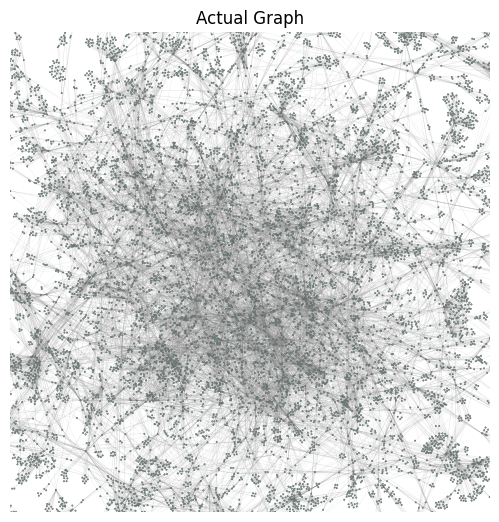

In [24]:
fig, ax = nw.draw_netwulf(real_graph)
plt.title(f"Actual Graph")
plt.show()

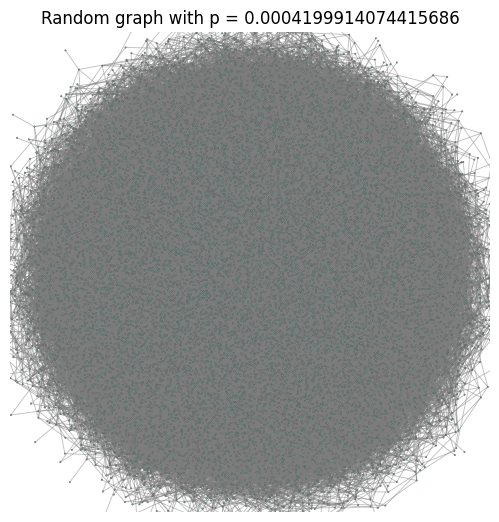

In [18]:
fig, ax = nw.draw_netwulf(positions_random)
plt.title(f"Random graph with p = {p}")
plt.show()

In [7]:
# What regime does the network fall into? 

critical_point = 1/N 
if p < critical_point: 
    print("Below the critical point - subcritical regime")
else: 
    print(f"Above the critical point {critical_point}")
    if p > np.log(N)/N: 
        print("Connected regime")
    else: 
        print("Supercritical regime")

Above the critical point 0.00022138587558113792
Supercritical regime


Answer the following questions (max 200 words in total):

- What regime does your random network fall into? Is it above or below the critical threshold?
According to the textbook, what does the network's structure resemble in this regime?

**Our network is above the critical threshold and is a supercritical regime. The textbook states the supercritical regimes are disconnected graphs where the giant component is made up of a fraction of the nodes forming cycles and loops while the rest of the nodes form small trees.**
- Based on your visualizations, identify the key differences between the actual and the random networks. Explain whether these differences are consistent with theoretical expectations.

**The random network looks to have a much larger giant component than the real network. This suggests that the real network exhibits more of a heavy-tailed distribution than the random network as the bulk of the edges tend to be focused in the smaller giant component in the real network while the edges are more evenly distributed in the random network. This is in line with theoretical expectations since real world distributions are more likely to be heavy-tailed.**

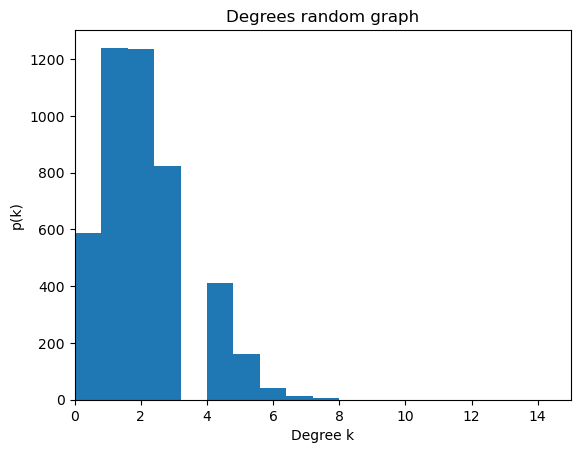

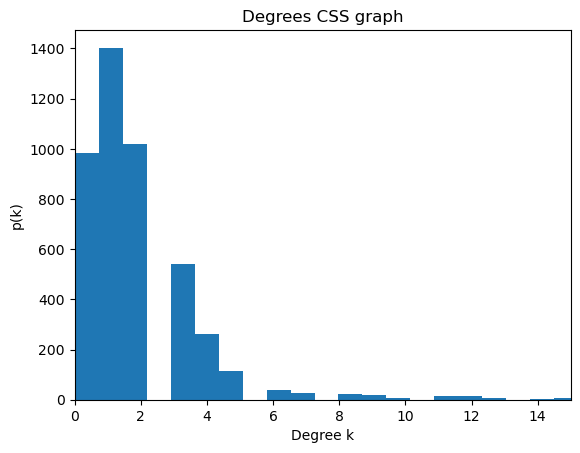

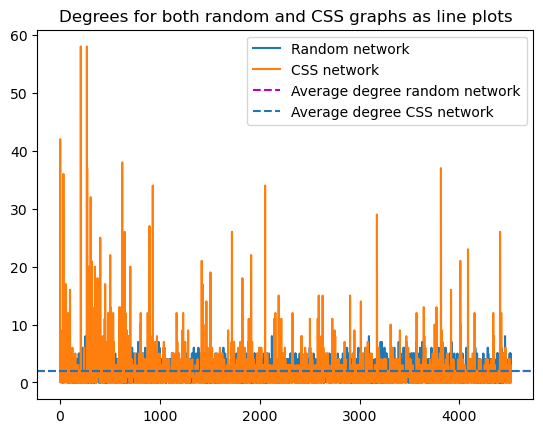

In [8]:
# Degree distribution 

def plot_graphs(G1, G2, lim, lim2):

    degrees1 = [degree for node, degree in G1.degree()]
    degrees2 = [degree for node, degree in G2.degree()]
    av_degree1 = np.mean(degrees1)
    av_degree2 = np.mean(degrees2)

    plt.hist(degrees1, bins=10)
    plt.title("Degrees random graph")
    plt.ylabel("p(k)")
    plt.xlabel("Degree k")
    plt.xlim(lim)
    plt.show()

    plt.hist(degrees2, bins=80)
    plt.title("Degrees CSS graph")
    plt.ylabel("p(k)")
    plt.xlabel("Degree k")
    plt.xlim(lim2)
    plt.show()

    # Plot both degree distribtuions as line plots 
    plt.plot(degrees1, label="Random network")
    plt.plot(degrees2, label="CSS network")
    plt.axhline(y = av_degree1, c="m", linestyle='--', label="Average degree random network") 
    plt.axhline(y = av_degree2, linestyle='--', label="Average degree CSS network") 
    plt.title("Degrees for both random and CSS graphs as line plots")
    plt.legend()
    plt.show()


limits1 = [0,15]
limits2 = [0,15]
plot_graphs(random_graph, CSS_graph, limits1, limits2)


Answer the following questions (max 200 words in total):
- Does the average degree meaningfully represents the network's characteristics, especially in light of the insights gained from exploring heavy-tailed distributions? Discuss its adequacy or limitations in capturing the essence of the network's structural properties.

**The average degree is not a good indicator for the network's characteristics given that our network is a heavy-tailed supercritical network. In heavy-tailed distributions, the big jump principle means that most of the sum is contributed by the largest values of the sample, which aren't a good representation of the entire network. The average degree may lead us to believe that the graph is more connected than it appears, because the small tree components contribute much less to the average degree. In reality, the nodes in the giant component have large degrees closer to the mean, while the other components have much fewer connections.**
- What differences can you observe between the real and the random distributions? How does the shape of the degree distribution for each network inform us about the network's properties? (max 150 words)
****

### Part 2 - Network Analysis in Computational Social Science


In [25]:
def calc_assortativity_coeff(graph, nr_edges):
    node_to_index = {node: i for i, node in enumerate(graph.nodes())}
    degrees = [0] * len(graph.nodes())
    
    for node, degree in nx.degree(graph):
        degrees[node_to_index[node]] = degree
    
    total = 0 
    for edge in graph.edges():
        node1, node2 = node_to_index[edge[0]], node_to_index[edge[1]]
        degree_product = degrees[node1] * degrees[node2]
        total += degree_product

    sum_degrees_squared = sum(degree ** 2 for degree in degrees)
    avg_degree_product = total / nr_edges
    same_type_edges = avg_degree_product / sum_degrees_squared
    expected_same_type_edges = sum_degrees_squared / nr_edges
    AC = (same_type_edges - (expected_same_type_edges)) / (1 - expected_same_type_edges)

    return AC


In [26]:

nr_edges = CSS_graph.number_of_edges()
AC = calc_assortativity_coeff(CSS_graph, nr_edges)

print(f"Assortativity Coefficient: {AC}")

Assortativity Coefficient: 1.0290182801940655


In [27]:
# Implement the configuration model using the double edge swap algorithm to generate random networks

def generate_edges(network_copy): 
    edges = network_copy.edges() 
    e1 = random.choice(list(edges))
    e2 = random.choice(list(edges)) 
    while e1 == e2: 
        e2 = random.choice(list(edges))
    
    return e1, e2

def double_swap_alg(graph): 
    network_copy = graph.copy() 
    nr_of_edges = network_copy.number_of_edges()

    for _ in tqdm(range(10 * nr_of_edges)):
        
        # Select two distinct edges
        e1, e2 = random.sample(list(network_copy.edges()), 2)

        # Create new edges
        e1_prime = (e1[0], e2[1])
        e2_prime = (e2[0], e1[1])

        # Flip the direction 50% of the time 
        if random.random() >= 0.5:
            e1_prime = (e1_prime[1], e1_prime[0])

        # Remove and add edges 
        network_copy.remove_edges_from([e1, e2])
        network_copy.add_edges_from([e1_prime, e2_prime])

    return network_copy

In [28]:
""" Show that the degree of the nodes in the original network and the new randomized network are the same """

new_graph = double_swap_alg(CSS_graph)


  0%|          | 410/475930 [00:16<5:15:54, 25.09it/s]


KeyboardInterrupt: 

In [29]:
# load randomized graph
with open('CSS_graph_W6.pickle', 'rb') as file:
    new_graph = pickle.load(file)

In [30]:
print(f"# Edges in original: {CSS_graph.number_of_edges()}")
print(f"# Edges in randomized: {new_graph.number_of_edges()}")

# Edges in original: 47593
# Edges in randomized: 53184


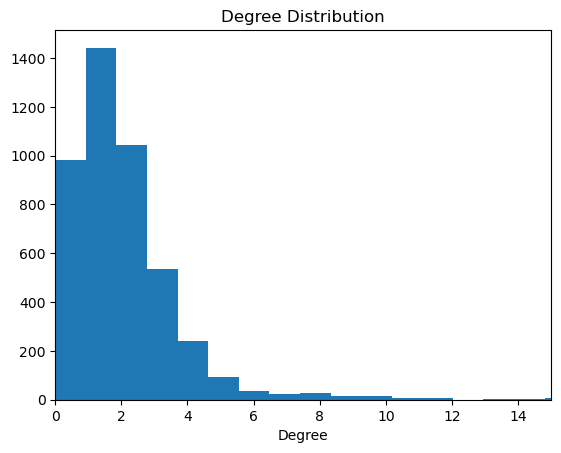

In [14]:
new_graph_degree = new_graph.degree()
degrees_list = [deg for n, deg in new_graph_degree]

plt.hist(degrees_list, bins=40) 
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.xlim(0, 15)
plt.show()


In [15]:
# Generate at least 100 random networks using configuration model 

n = 100
networks = []
AC_networks = []

for _ in tqdm(range(n)):
    new_network = double_swap_alg(CSS_graph)
    networks.append(new_network)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [6:33:10<00:00, 235.90s/it]


In [16]:
# Save new networks 

with open('new_networks.txt', 'w') as file:
    for netw in networks:
        file.write(str(netw) + '\n')

In [17]:
for network in tqdm(networks):
    AC_new = calc_assortativity_coeff(network, network.number_of_edges())
    AC_networks.append(AC_new)

  5%|▌         | 5/100 [00:00<00:02, 39.32it/s]

100%|██████████| 100/100 [00:01<00:00, 95.05it/s]


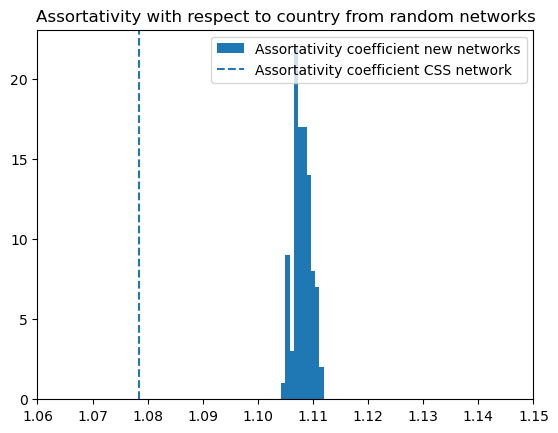

In [29]:
# Plot Assortativity

plt.hist(AC_networks, label="Assortativity coefficient new networks")
plt.axvline(x=AC, linestyle='--', label="Assortativity coefficient CSS network")
plt.title("Assortativity with respect to country from random networks")
plt.xlim([1.06,1.15])
plt.legend()
plt.show() 


In [30]:
def calc_assortativity_deg_coeff(graph):

    sum_deg = 0
    av_deg1, av_deg2, deg_sq1, deg_sq2 = 0, 0, 0, 0

    for u,v in graph.edges():
        av_deg1 += graph.degree(u)
        deg_sq1 += graph.degree(u)**2
        av_deg2 += graph.degree(v)
        deg_sq2 += graph.degree(v)**2
        sum_deg += graph.degree(u) * graph.degree(v)

    av_deg1 /= graph.number_of_edges()
    av_deg2 /= graph.number_of_edges()
    deg_sq1 /= graph.number_of_edges()
    deg_sq2 /= graph.number_of_edges()
    sum_deg /= graph.number_of_edges()

    DAC = (sum_deg - (av_deg1 * av_deg2)) / np.sqrt((deg_sq1 - av_deg1**2) * (deg_sq2 - av_deg2**2))
    return DAC


In [31]:
DAC = calc_assortativity_deg_coeff(CSS_graph)

DAC_networks = []
for network in networks:
    DAC = calc_assortativity_deg_coeff(network)
    DAC_networks.append(DAC)

Reflection questions (max 250 words for the 3 questions)  
- Assortativity by degree. Were the results of the degree assortativity in line with your expectations? Why or why not? 

**Our results were not in line with what we expected. We expected that the assortativity of the real graph would be higher than the assortativity of the random graphs, but we found that it was significantly lower. Higher assortativity implies that authors collaborate in clusters with other authors that collaborate the same amount, which we thought would be more assortative than a random graph.**
- Edge flipping. In the process of implementing the configuration model, you were instructed to flip the edges (e.g., changing e_1 from (u,v) to (v,u)) 50% of the time. Why do you think this step is included?  

**We do this to make sure that the graph is not biased due to the initial sorting of the edges. By flipping the edges half the time, we are changing the order of the edges so that selecting the edges is more random on every configuration.**
- Distribution of assortativity in random networks. Describe the distribution of degree assortativity values you observed for the random networks. Was the distribution pattern expected? Discuss how the nature of random network generation (specifically, the configuration model and edge flipping) might influence this distribution and whether it aligns with theoretical expectations.

**The assortativity of the random networks follows a Gaussian distribution. With the configuration model, we are trying to create random networks while preserving some elements of the graphs structure. It is not unusual to see that the assortativity does not follow a uniform distribution because assortativity is dependent on the structure of the network, which in this case is not completely random.**

Exercise 2 - Central nodes 

In [32]:
# Degree centrality - how easy to reach other nodes from a specific node 

def calc_degree_centrality(graph): 
    N = graph.number_of_edges()
    C = []
    for node in graph: 
        dist = nx.single_source_shortest_path(graph, node)
        av_dist = sum(len(path) - 1 for path in dist.values())/ N
        if av_dist != 0:
            C.append((N - 1)/av_dist)
        else: 
            C.append(0)

    return C

centrality_degrees = calc_degree_centrality(CSS_graph)

Find the 5 most central scientists according to the closeness centrality. What role do you imagine scientists with high closeness centrality play?

In [41]:
closeness_centrality = nx.closeness_centrality(CSS_graph)
closeness_centrality_list = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

top_five_CC = [item[0] for item in closeness_centrality_list[:5]]

print(f"Author ID for top 5 authors based on CC: {top_five_CC}")


Author ID for top 5 authors based on CC: ['https://openalex.org/A5079596102', 'https://openalex.org/A5021346979', 'https://openalex.org/A5009232244', 'https://openalex.org/A5046546654', 'https://openalex.org/A5031799782']


**Top 5 According to Closeness Centrality:**
1. Márton Karsai: 'https://openalex.org/A5079596102'
2. Filippo Menczer: 'https://openalex.org/A5021346979'
3. Iyad Rahwan: 'https://openalex.org/A5009232244'
4. Alessandro Vespignani: 'https://openalex.org/A5046546654'
5. Nicola Perra: 'https://openalex.org/A5031799782'

Find the 5 most central scientists according to eigenvector centrality.

In [44]:
eigenvec_centrality = nx.eigenvector_centrality(CSS_graph)
eigenvec_centrality_list = sorted(eigenvec_centrality.items(), key=lambda x: x[1], reverse=True)

top_five_EC = [item[0] for item in eigenvec_centrality_list[:5]]

print(f"Author id for top 5 authors based on EC: {top_five_EC}")

Author id for top 5 authors based on EC: ['https://openalex.org/A5021346979', 'https://openalex.org/A5046546654', 'https://openalex.org/A5031799782', 'https://openalex.org/A5011228873', 'https://openalex.org/A5079596102']


**Top 5 According to Eigenvector Centrality:**
1. Filippo Menczer: 'https://openalex.org/A5021346979'
2. Alessandro Vespignani: 'https://openalex.org/A5046546654'
3. Nicola Perra: 'https://openalex.org/A5031799782'
4. Alessandro Flammini: 'https://openalex.org/A5011228873'
5. Márton Karsai: 'https://openalex.org/A5079596102'

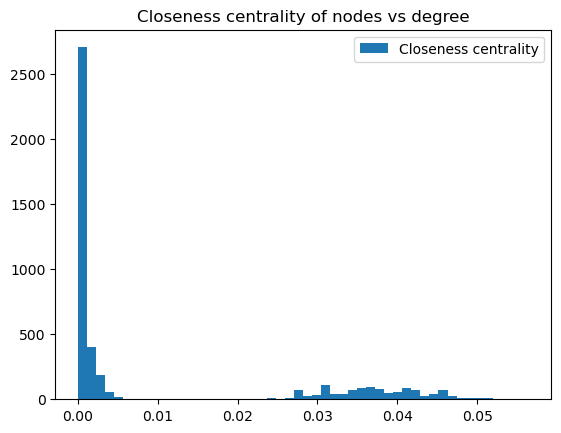

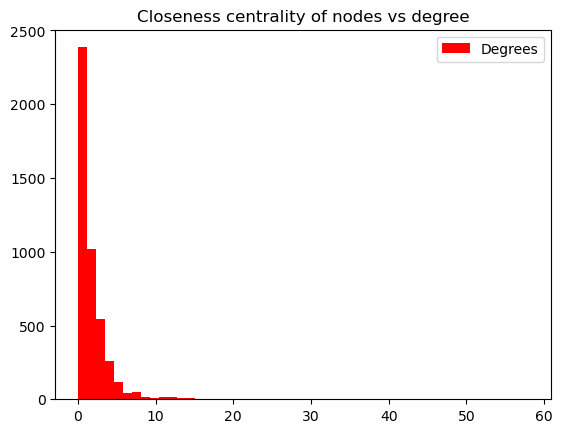

In [54]:
# Plot the closeness centrality of nodes vs their degree

CC_values = closeness_centrality.values()
CSS_degrees = [degree for node, degree in CSS_graph.degree()]

plt.hist(CC_values, bins=50, label="Closeness centrality")
plt.title("Closeness centrality of nodes vs degree")
plt.legend()
plt.show()

plt.hist(CSS_degrees, bins=50, color="r", label="Degrees")
plt.title("Closeness centrality of nodes vs degree")
plt.legend()
plt.show()

Is there a correlation between the two? Did you expect that? Why?

****

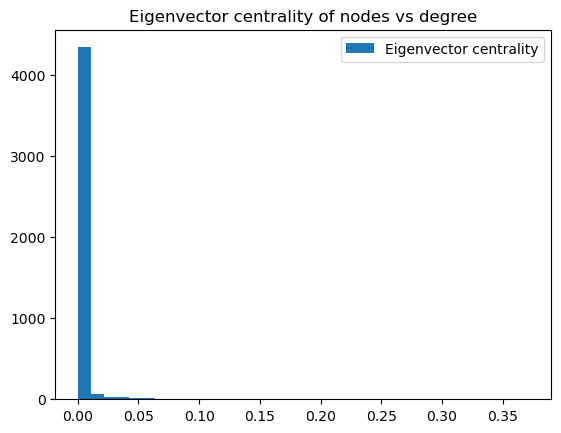

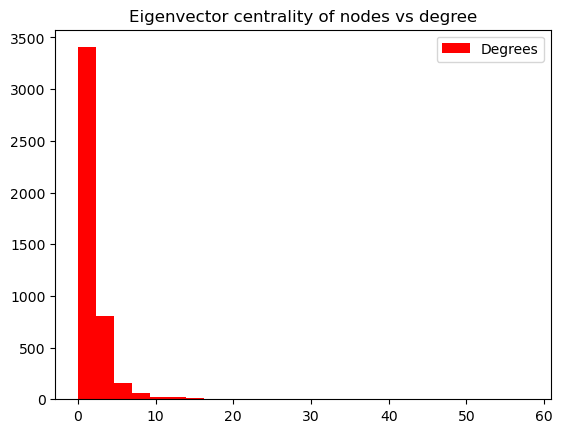

In [58]:
# Plot the eigenvector centrality of nodes vs their degree

EC_values = eigenvec_centrality.values()

plt.hist(EC_values, bins=35, label="Eigenvector centrality")
plt.title("Eigenvector centrality of nodes vs degree")
plt.legend()
plt.show()

plt.hist(CSS_degrees, bins=25, color="r", label="Degrees")
plt.title("Eigenvector centrality of nodes vs degree")
plt.legend()
plt.show()

Is there a correlation between the two? Did you expect that? Why?

### Part 3 - Words that characterize Computational Social Science communities


- TF: Term Frequency
- IDF: Inverse Document Frequency 

a score for measuring the importance of a word in a text. 

Exercise 1)

In [59]:
import community 

CSS_partition = community.best_partition(CSS_graph)

communities = {}
for node, c in CSS_partition.items(): 
    if c not in communities:
        communities[c] = []
    communities[c].append(node)

In [68]:
abstract_df = pd.read_csv("data/Abstract_dataframe_W7.csv")
articles_df = pd.read_csv("data/ArticlesW3.csv")

# Drop unnamed columns
abstract_df.drop(columns=[col for col in abstract_df.columns if col is None], inplace=True)
articles_df.drop(columns=[col for col in articles_df.columns if col is None], inplace=True)
 


In [61]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import json
import string 

# From exercises week 7 

def convert_abstract_to_dict(s):
    try:
        s = s.replace("'", "\"")
        dict_from_string = json.loads(s)
        return dict_from_string
    except: 
        return None

def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')

    clean_text = []

    for word in text.split():
        if word in stopwords:
            continue
        else:
            clean_text.append(word)
    clean_line = ' '.join(clean_text)
    return clean_line

def inverted_to_plaintext(inverted_index):
    inverted_index_dict = convert_abstract_to_dict(inverted_index)
    if inverted_index_dict is not None:
        max_position = max([pos for positions in inverted_index_dict.values() if positions is not None for pos in positions])

        text_array = ["" for _ in range(max_position + 1)]  
        for word, positions in inverted_index_dict.items():
            if positions is not None:
                for position in positions:
                    text_array[position] = word

        text_array = [str(elem) for elem in text_array if elem is not None]  
        text = ' '.join(text_array)
        text_no_stopwords = remove_stopwords(text)
        return text_no_stopwords
    else:
        return None

def tokenize_text(text):
    if text is None:
        return []
    text = text.lower()
    tokens = word_tokenize(text)
    translator = str.maketrans('', '', string.punctuation)
    tokens = [token.translate(translator) for token in tokens]
    return tokens

articles_df['text'] = articles_df['abstract_inverted_index'].apply(inverted_to_plaintext)
articles_df['tokens'] = articles_df['text'].apply(tokenize_text)

tokens_list = []
for tokens in articles_df['tokens']:
    tokens_list.extend(tokens)


In [69]:
articles_df

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id,publication_year,cited_by_count,title,abstract_inverted_index,author_ids
0,0,0,0,0,0,https://openalex.org/W2738609380,2019,25,Hipsters on networks: How a minority group of ...,"{'The': [0, 125], 'spread': [1], 'of': [2, 17,...","['https://openalex.org/A5031780796', 'https://..."
1,1,1,1,1,1,https://openalex.org/W2738609380,2019,25,Hipsters on networks: How a minority group of ...,"{'The': [0, 125], 'spread': [1], 'of': [2, 17,...","['https://openalex.org/A5031780796', 'https://..."
2,2,2,2,2,2,https://openalex.org/W2738609380,2019,25,Hipsters on networks: How a minority group of ...,"{'The': [0, 125], 'spread': [1], 'of': [2, 17,...","['https://openalex.org/A5031780796', 'https://..."
3,3,3,3,3,3,https://openalex.org/W3142588439,2010,2190,"Networks, Crowds, and Markets","{'Are': [0, 30], 'all': [1, 32], 'film': [2], ...","['https://openalex.org/A5017669758', 'https://..."
4,4,4,4,4,4,https://openalex.org/W2432978112,2006,1572,Group formation in large social networks,"{'The': [0], 'processes': [1], 'by': [2, 221, ...","['https://openalex.org/A5081744093', 'https://..."
...,...,...,...,...,...,...,...,...,...,...,...
5615,5615,5615,5615,5615,5615,https://openalex.org/W2042907718,2011,16,Judgments of Cause and Blame: Sensitivity to I...,NaN,"['https://openalex.org/A5005005137', 'https://..."
5616,5616,5616,5616,5616,5616,https://openalex.org/W2403239411,2016,14,Using Bayesian networks to guide the assessmen...,"{'When': [0], 'new': [1], 'forensic': [2, 251]...","['https://openalex.org/A5012762776', 'https://..."
5617,5617,5617,5617,5617,5617,https://openalex.org/W2047756825,2015,13,Causal analysis for attributing responsibility...,"{'An': [0], 'important': [1], 'challenge': [2]...","['https://openalex.org/A5053852359', 'https://..."
5618,5618,5618,5618,5618,5618,https://openalex.org/W2047756825,2015,13,Causal analysis for attributing responsibility...,"{'An': [0], 'important': [1], 'challenge': [2]...","['https://openalex.org/A5053852359', 'https://..."


Find all the abstracts of papers written by a member of community c

In [63]:
def find_abstract(df, author_list): 
    array_with_tokens = []
    for author in author_list:
        row = df[df['author_ids'].apply(lambda val: author in val)]
        abstract = row["tokens"]
        if abstract not in array_with_tokens:
            array_with_tokens.append(abstract)
        return array_with_tokens 

abstracts_per_community = {}
for c, author_list in communities.items():
    array_with_tokens = find_abstract(articles_df, author_list)
    abstracts_per_community[c] = array_with_tokens
    ## Create a long array that stores all abstracts tokens

print(abstracts_per_community)

{0: [3      [are, film, stars, linked, kevin, bacon, , why...
70     [are, film, stars, linked, kevin, bacon, , why...
71     [are, film, stars, linked, kevin, bacon, , why...
106    [there, number, domains, agents, must, collect...
107    [there, number, domains, agents, must, collect...
170                                                   []
171                                                   []
172                                                   []
196                                                   []
197                                                   []
206    [this, essay, introduces, symposium, computer,...
207    [this, essay, introduces, symposium, computer,...
219    [in, previous, chapter, , considered, social, ...
Name: tokens, dtype: object], 1: [395                                                   []
396    [the, terms, “, posttruth, ”, “, fake, news, ”...
397    [misinformation, undermine, wellfunctioning, d...
398                                              

In [64]:
# Calculate tf 
def calc_tf(text): 
    tf_dict = {}
    for word in text.split():
        tf = text.count(word) / len(text)
        tf_dict[word] = tf 
    return tf_dict 

# Calculate idf 
def calc_texts_with_word(tokens_list, word):
    count = sum(1 for text in tokens_list if word in text)
    return count 

def calc_idf(tokens_list):
    idf_dict = {}
    all_words = set(word for text in tokens_list for word in text.split())
    num_texts = len(tokens_list)
    for word in all_words:
        texts_with_word = sum(1 for text in tokens_list if word in text)
        idf = np.log(num_texts / (1 + texts_with_word))
        idf_dict[word] = idf
    return idf_dict



In [65]:
# Find top 5 communities 

def find_top_communities(number_of_c, communities):
    top_communities = []
    sorted_communities = sorted(communities, key=lambda x: len(x[1]), reverse=True)
    for i in range(min(number_of_c, len(sorted_communities))):
        top_communities.append(sorted_communities[i][0])
    return top_communities



In [66]:
nr_of_communities = 5
top_communites = find_top_communities(nr_of_communities, communities.items())
print(f"The top {nr_of_communities} number of communinties are: {top_communites}")

The top 5 number of communinties are: [12, 97, 14, 31, 377]


In [67]:
# Find the top five terms in the top five communities 



- Describe similarities and differences between the communities.
- Why aren't the TFs not necessarily a good description of the communities?
- Next, we calculate IDF for every word.
- What base logarithm did you use? Is that important?

Calculate TF_IDF for the top 9 communities (by number of authors). 

- List the 10 top TF words
- List the 10 top TF-IDF words
- List the top 3 authors (by degree)
- Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?